In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import emcee
import pandas as pd
from tqdm import tqdm
from scipy.spatial import KDTree
import pdr
from astropy.visualization import ZScaleInterval
from scipy.signal import medfilt2d

In [2]:
from glcat_lightcurve_utils import counts2mag
from glcat_photometry_utils import *

In [3]:
ncat = pd.read_csv('ncat_240616.csv',index_col=None)
nmod = pd.read_csv('ncat_nuv_fit_240616.csv',index_col=None)
count = pdr.read('/Users/cm/github/gphoton2_refactor/gPhoton2/test_data/e23456/e23456-nd-b00-ffull-image-r.fits')

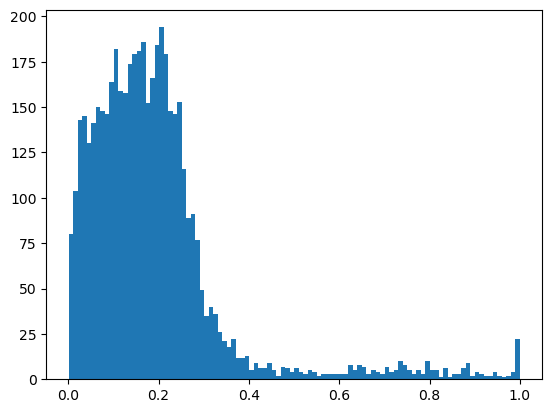

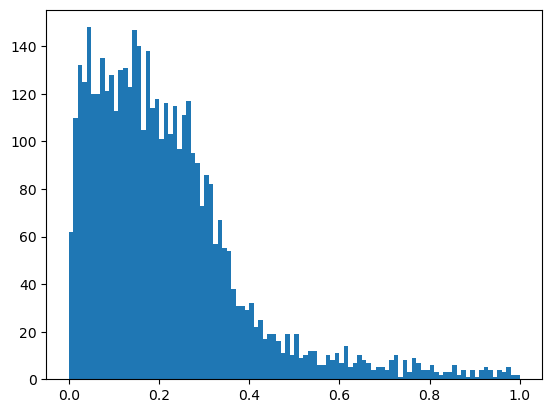

In [4]:
plt.figure()
plt.hist(nmod['cps_lower_conf']/nmod['cps'],bins=100);
plt.figure()
plt.hist(nmod['cps_upper_conf']/nmod['cps'],bins=100,range=[0,1]);

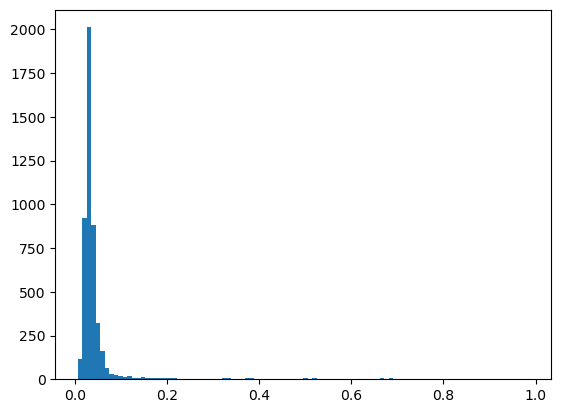

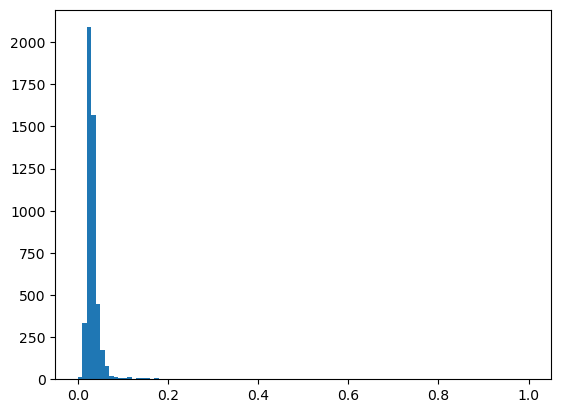

In [5]:
plt.figure()
plt.hist(nmod['bg_cps_lower_conf']/nmod['bg_cps'],bins=100);
plt.figure()
plt.hist(nmod['bg_cps_upper_conf']/nmod['bg_cps'],bins=100,range=[0,1]);


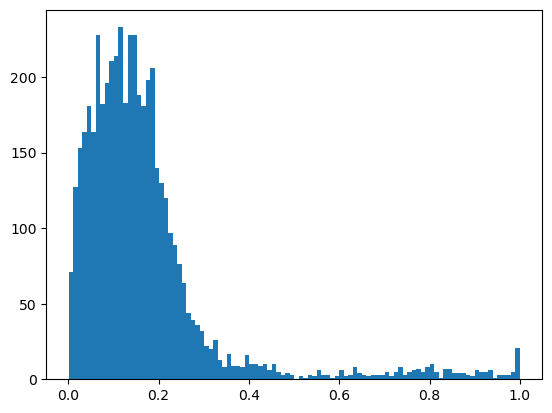

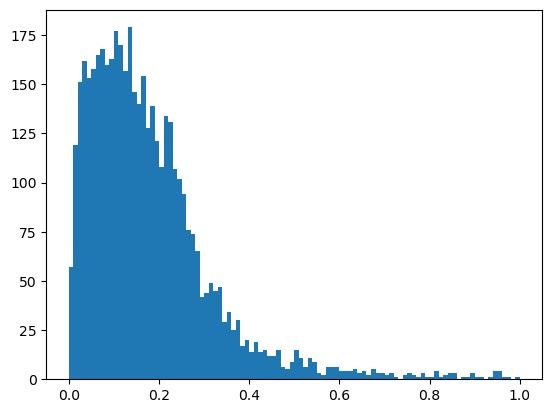

In [6]:
plt.figure()
plt.hist(nmod['sigma_lower_conf']/nmod['sigma'],bins=100);
plt.figure()
plt.hist(nmod['sigma_upper_conf']/nmod['sigma'],bins=100,range=[0,1]);


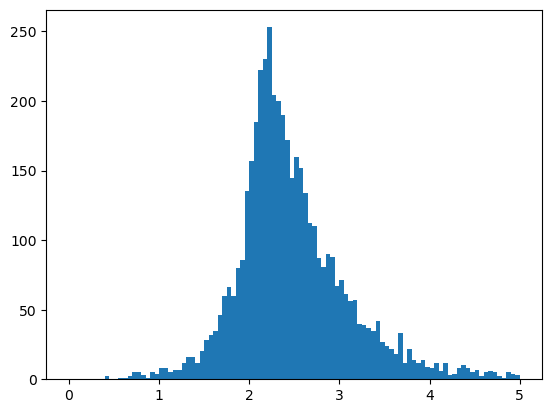

In [7]:
plt.hist(nmod['sigma'],bins=100,range=[0,5]);

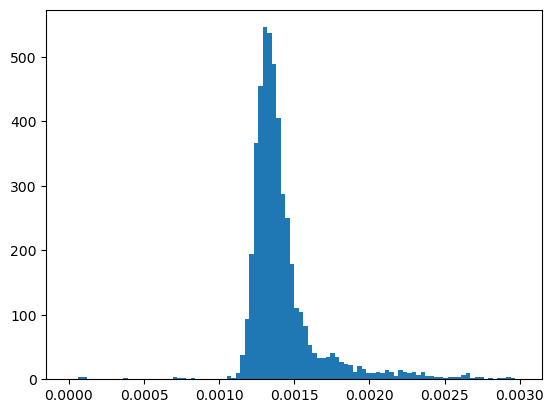

In [8]:
plt.hist(nmod['bg_cps'],bins=100,range=[0,0.003]);

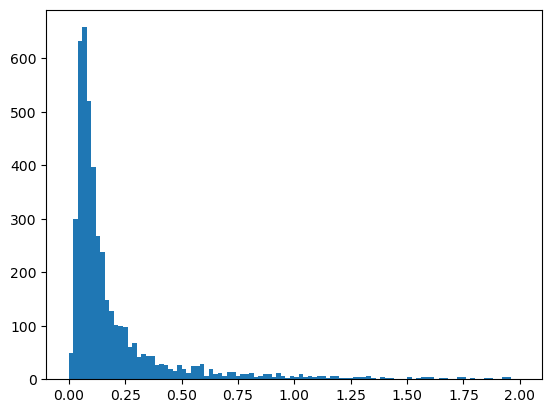

In [9]:
plt.hist(nmod['cps'],bins=100,range=[0,2]);

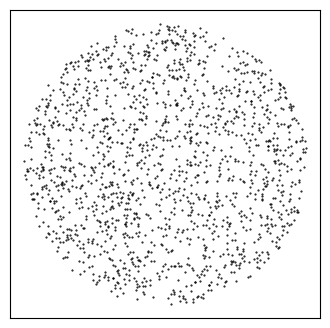

In [42]:
ix = np.where((nmod['sigma']<5) & (nmod['cps']>0.1) & (nmod['cps']<0.4) &
              (nmod['bg_cps']<0.002) & (nmod['bg_cps']>0.0012) &
              (ncat['NUV_MASK_APER6']==0) & (ncat['NUV_EDGE_APER6']==0))
x,y = (ncat['NUV_XCENTER'].values[ix],
       ncat['NUV_YCENTER'].values[ix])
plt.figure(figsize=(4,4))
plt.plot(x,y,'k.',markersize=1)
plt.xticks([]);plt.yticks([]);
plt.gca().invert_yaxis()
#plt.gca().invert_xaxis()

bg = nmod['bg_cps'].values[ix]

In [44]:
blank = np.full(count['CNT'].shape,np.nan)
blank[np.array(x,dtype='int16'),
      np.array(y,dtype='int16')]=bg
np.nanmax(blank)

0.0019981643889539

In [45]:
def idw_interpolation_k_nearest(data, k=10, power=2):
    filled_data = data.copy()
    n, m = data.shape

    # Create a list of valid (non-NaN) data points
    valid_mask = ~np.isnan(data)
    valid_points = np.argwhere(valid_mask)
    valid_values = data[valid_mask]

    if len(valid_points) > 0:
        # Create a KDTree for efficient nearest neighbor search
        tree = KDTree(valid_points)

        # Create a grid of points to interpolate
        grid_points = np.argwhere(np.isnan(data))

        if len(grid_points) > 0:
            # Find the K nearest neighbors for each grid point
            distances, indices = tree.query(grid_points, k=k)

            # Calculate the weights based on inverse distance
            weights = 1.0 / (distances ** power)
            weights /= np.sum(weights, axis=1)[:, np.newaxis]

            # Perform interpolation using weighted sum of K nearest neighbors
            interpolated_values = np.sum(weights * valid_values[indices], axis=1)

            # Fill the interpolated values into the data array
            filled_data[grid_points[:, 0], grid_points[:, 1]] = interpolated_values

    return filled_data

In [46]:
def distance_mask(arr, D):
   rows, cols = arr.shape
   center_row, center_col = rows // 2, cols // 2
   
   row_indices = np.arange(rows)
   col_indices = np.arange(cols)
   
   row_grid, col_grid = np.meshgrid(row_indices, col_indices, indexing='ij')
   
   distances = np.sqrt((row_grid - center_row)**2 + (col_grid - center_col)**2)
   
   mask = distances > D
   
   arr_masked = arr.copy()
   arr_masked[mask] = np.nan
   
   return arr_masked

In [62]:
%time img = idw_interpolation_k_nearest(blank,k=50,power=0.8)

CPU times: user 43.5 s, sys: 5.15 s, total: 48.7 s
Wall time: 48.7 s


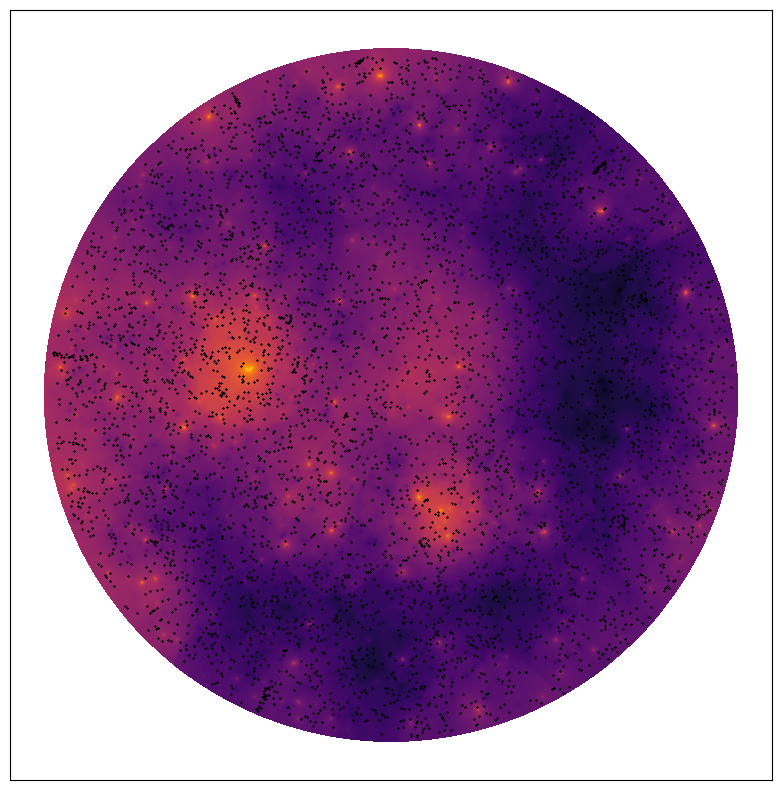

In [63]:
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(np.log10(distance_mask(medfilt2d(img,3), 1400)),cmap="inferno",origin="lower",)
ax.set_xticks([]);ax.set_yticks([]);
ax.plot(ncat['NUV_XCENTER'].values,
       ncat['NUV_YCENTER'].values,'kx',markersize=1)

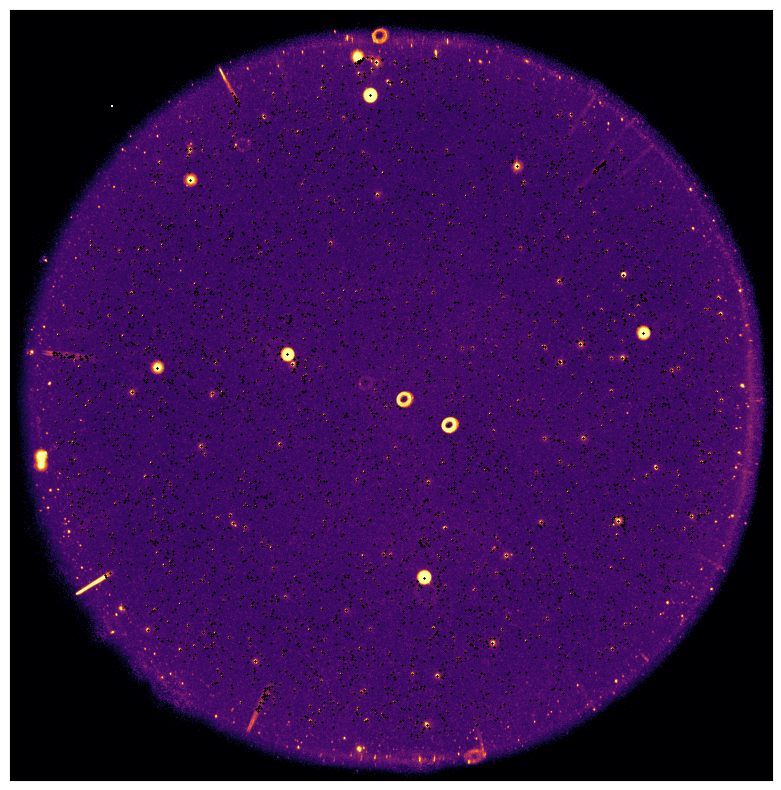

In [49]:
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(ZScaleInterval()(count['CNT']),cmap="inferno",origin="lower")
ax.set_xticks([]);ax.set_yticks([]);
ax.plot(ncat['NUV_XCENTER'].values,
       ncat['NUV_YCENTER'].values,'kx',markersize=1)